In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
import statsmodels.api as sm
import optuna
import warnings

# from featurewiz import FeatureWiz

warnings.filterwarnings("ignore")

from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.model_selection import *
from scipy.stats import linregress
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import UnivariateSpline

XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ['dlopen(/Applications/anaconda3/lib/python3.11/site-packages/xgboost/lib/libxgboost.dylib, 0x0006): Symbol not found: ___kmpc_dispatch_deinit\n  Referenced from: <ADFDEDDC-951B-34BE-87DB-F5CA2631E6D0> /Applications/anaconda3/lib/python3.11/site-packages/xgboost/lib/libxgboost.dylib\n  Expected in:     <8AE74FFC-75EE-374B-BA46-A70944EA81BD> /Applications/anaconda3/lib/libomp.dylib']


## Agregar detailed data

In [ ]:
df_detailed_results = pd.concat(
    [
        pd.read_csv("MRegularSeasonDetailedResults.csv"),
        pd.read_csv("WRegularSeasonDetailedResults.csv"),
    ]
)
df_detailed_results["MM"] = 0

In [ ]:
df_detailed_tourney = pd.concat(
    [
        pd.read_csv("MNCAATourneyDetailedResults.csv"),
        pd.read_csv("WNCAATourneyDetailedResults.csv"),
    ]
)
df_detailed_tourney["MM"] = 1

In [ ]:
df_detailed_results = pd.concat(
    [
        df_detailed_results,
        # pd.read_csv( "WRegularSeasonDetailedResults.csv"),
        df_detailed_tourney,
        # pd.read_csv( "WNCAATourneyDetailedResults.csv"),
    ],
    ignore_index=True,
)

In [ ]:
seeds = pd.read_csv("MMasseyOrdinals.csv")

In [ ]:
seeds = seeds.groupby(["Season", "RankingDayNum", "TeamID"], as_index=False)[
    "OrdinalRank"
].mean()

In [ ]:
seeds["OrdinalRank"] = seeds["OrdinalRank"].astype(int)

In [ ]:
df_detailed_results["WDRDiff"] = df_detailed_results["WDR"] - df_detailed_results["LDR"]
df_detailed_results["LDRDiff"] = df_detailed_results["LDR"] - df_detailed_results["WDR"]
df_detailed_results["WORDiff"] = df_detailed_results["WOR"] - df_detailed_results["LOR"]
df_detailed_results["LORDiff"] = df_detailed_results["LOR"] - df_detailed_results["WOR"]
df_detailed_results["WFGADiff"] = (
    df_detailed_results["WFGA"] - df_detailed_results["LFGA"]
)
df_detailed_results["LFGADiff"] = (
    df_detailed_results["LFGA"] - df_detailed_results["WFGA"]
)
df_detailed_results["WTODiff"] = df_detailed_results["WTO"] - df_detailed_results["LTO"]
df_detailed_results["LTODiff"] = df_detailed_results["LTO"] - df_detailed_results["WTO"]
df_detailed_results["WAstDiff"] = (
    df_detailed_results["WAst"] - df_detailed_results["LAst"]
)
df_detailed_results["LAstDiff"] = (
    df_detailed_results["LAst"] - df_detailed_results["WAst"]
)
df_detailed_results["WFGM3Diff"] = (
    df_detailed_results["WFGM3"] - df_detailed_results["LFGM3"]
)
df_detailed_results["LFGM3Diff"] = (
    df_detailed_results["LFGM3"] - df_detailed_results["WFGM3"]
)
df_detailed_results["WFGA3Diff"] = (
    df_detailed_results["WFGA3"] - df_detailed_results["LFGA3"]
)
df_detailed_results["LFGA3Diff"] = (
    df_detailed_results["LFGA3"] - df_detailed_results["WFGA3"]
)
df_detailed_results["WScoreDiff"] = (
    df_detailed_results["WScore"] - df_detailed_results["LScore"]
)
df_detailed_results["LScoreDiff"] = (
    df_detailed_results["LScore"] - df_detailed_results["WScore"]
)

In [ ]:
# Get the minimum ranking day number for each season
min_ranking_daynums = seeds.groupby("Season")["RankingDayNum"].min()

# Merge the ranking column into the first dataframe for each season
merged_dfs = []
for season, df1_season in df_detailed_results.groupby("Season"):
    df2_season = seeds[seeds["Season"] == season]
    min_ranking_daynum = min_ranking_daynums[season]
    df1_season.rename(columns={"WTeamID": "TeamID"}, inplace=True)
    # Only merge the ranking column if there are rows in df2_season with a daynum greater than or equal to the minimum ranking day number
    if not df2_season[df2_season["RankingDayNum"] >= min_ranking_daynum].empty:
        merged_df_season = pd.merge_asof(
            df1_season.sort_values("DayNum"),
            df2_season.sort_values("RankingDayNum")[
                ["TeamID", "RankingDayNum", "OrdinalRank"]
            ],
            by="TeamID",
            left_on="DayNum",
            right_on="RankingDayNum",
            direction="backward",
        )
        merged_df_season["OrdinalRank"] = merged_df_season["OrdinalRank"].fillna(
            method="ffill"
        )
        merged_dfs.append(merged_df_season)

# Combine the merged dataframes for each season into a single dataframe
merged_df = pd.concat(merged_dfs)

In [10]:
df_detailed_results = merged_df.copy()

In [11]:
del merged_df

In [ ]:
df_detailed_results.rename(
    columns={"TeamID": "WTeamID", "OrdinalRank": "WTeamRank"}, inplace=True
)

In [ ]:
# Get the minimum ranking day number for each season
min_ranking_daynums = seeds.groupby("Season")["RankingDayNum"].min()

# Merge the ranking column into the first dataframe for each season
merged_dfs = []
for season, df1_season in df_detailed_results.groupby("Season"):
    df2_season = seeds[seeds["Season"] == season]
    min_ranking_daynum = min_ranking_daynums[season]
    df1_season.rename(columns={"LTeamID": "TeamID"}, inplace=True)
    # Only merge the ranking column if there are rows in df2_season with a daynum greater than or equal to the minimum ranking day number
    if not df2_season[df2_season["RankingDayNum"] >= min_ranking_daynum].empty:
        merged_df_season = pd.merge_asof(
            df1_season.sort_values("DayNum"),
            df2_season.sort_values("RankingDayNum")[
                ["TeamID", "RankingDayNum", "OrdinalRank"]
            ],
            by="TeamID",
            left_on="DayNum",
            right_on="RankingDayNum",
            direction="backward",
        )
        merged_df_season["OrdinalRank"] = merged_df_season["OrdinalRank"].fillna(
            method="ffill"
        )
        merged_dfs.append(merged_df_season)

# Combine the merged dataframes for each season into a single dataframe
merged_df = pd.concat(merged_dfs)

In [ ]:
df_detailed_results = merged_df.copy()
del merged_df
# df_detailed_results.pop('RankingDayNum')
df_detailed_results.rename(
    columns={"TeamID": "LTeamID", "OrdinalRank": "LTeamRank"}, inplace=True
)

In [ ]:
df_detailed_results["WDRDiff"] = df_detailed_results["WDR"] - df_detailed_results["LDR"]
df_detailed_results["LDRDiff"] = df_detailed_results["LDR"] - df_detailed_results["WDR"]
df_detailed_results["WORDiff"] = df_detailed_results["WOR"] - df_detailed_results["LOR"]
df_detailed_results["LORDiff"] = df_detailed_results["LOR"] - df_detailed_results["WOR"]
df_detailed_results["WFGADiff"] = (
    df_detailed_results["WFGA"] - df_detailed_results["LFGA"]
)
df_detailed_results["LFGADiff"] = (
    df_detailed_results["LFGA"] - df_detailed_results["WFGA"]
)
df_detailed_results["WTODiff"] = df_detailed_results["WTO"] - df_detailed_results["LTO"]
df_detailed_results["LTODiff"] = df_detailed_results["LTO"] - df_detailed_results["WTO"]
df_detailed_results["WAstDiff"] = (
    df_detailed_results["WAst"] - df_detailed_results["LAst"]
)
df_detailed_results["LAstDiff"] = (
    df_detailed_results["LAst"] - df_detailed_results["WAst"]
)
df_detailed_results["WFGM3Diff"] = (
    df_detailed_results["WFGM3"] - df_detailed_results["LFGM3"]
)
df_detailed_results["LFGM3Diff"] = (
    df_detailed_results["LFGM3"] - df_detailed_results["WFGM3"]
)
df_detailed_results["WFGA3Diff"] = (
    df_detailed_results["WFGA3"] - df_detailed_results["LFGA3"]
)
df_detailed_results["LFGA3Diff"] = (
    df_detailed_results["LFGA3"] - df_detailed_results["WFGA3"]
)
df_detailed_results["WScoreDiff"] = (
    df_detailed_results["WScore"] - df_detailed_results["LScore"]
)
df_detailed_results["LScoreDiff"] = (
    df_detailed_results["LScore"] - df_detailed_results["WScore"]
)
df_detailed_results["WRankDiff"] = (
    df_detailed_results["WTeamRank"] - df_detailed_results["LTeamRank"]
)
df_detailed_results["LRankDiff"] = (
    df_detailed_results["LTeamRank"] - df_detailed_results["WTeamRank"]
)

In [ ]:
w_cols = [x for x in df_detailed_results.columns if ("W" in x) & ("Diff" in x)]

In [ ]:
w_cols.insert(0, "Season")

In [ ]:
w_cols.insert(1, "DayNum")

In [ ]:
w_cols.insert(2, "WTeamID")

In [ ]:
w_cols.insert(-1, "MM")

In [21]:
df_results_by_team = df_detailed_results[w_cols]

In [ ]:
df_results_by_team.columns = [x.replace("W", "") for x in w_cols]

In [ ]:
df_results_by_team["Win"] = 1

In [ ]:
l_cols = [x for x in df_detailed_results.columns if ("L" in x) & ("Diff" in x)]

In [ ]:
l_cols.insert(0, "Season")

In [ ]:
l_cols.insert(1, "DayNum")

In [ ]:
l_cols.insert(2, "LTeamID")

In [ ]:
l_cols.insert(-1, "MM")

In [29]:
df_results_l = df_detailed_results[l_cols]

In [ ]:
df_results_l.columns = [x.replace("L", "") for x in l_cols]

In [ ]:
df_results_l["Win"] = 0

In [ ]:
df_results_by_team = pd.concat([df_results_by_team, df_results_l], ignore_index=True)

In [ ]:
df_results_by_team["RankDiff"].fillna(0, inplace=True)

## GLMM

In [ ]:
list_cols = [
    "WFGM",
    "WFGA",
    "WFGM3",
    "WFGA3",
    "WFTM",
    "WFTA",
    "WOR",
    "WDR",
    "WAst",
    "WTO",
    "WStl",
    "WBlk",
    "WPF",
    "LFGM",
    "LFGA",
    "LFGM3",
    "LFGA3",
    "LFTM",
    "LFTA",
    "LOR",
    "LDR",
    "LAst",
    "LTO",
    "LStl",
    "LBlk",
    "LPF",
]

In [ ]:
w_list = [x for x in list_cols if "W" in x]

In [ ]:
l_list = [x for x in list_cols if "L" in x]

In [ ]:
t1_list = [x.replace("L", "T1_") for x in l_list]

In [ ]:
t2_list = [x.replace("L", "T2_") for x in l_list]

In [ ]:
regresults = df_detailed_results[df_detailed_results["MM"] == 0]
results = df_detailed_results[df_detailed_results["MM"] == 1]
seeds = pd.concat(
    [pd.read_csv("MNCAATourneySeeds.csv"), pd.read_csv("WNCAATourneySeeds.csv")],
    ignore_index=True,
)

seeds["Seed"] = pd.to_numeric(seeds["Seed"].str[1:3])
r1 = regresults[
    ["Season", "DayNum", "WTeamID", "WScore", "LTeamID", "LScore", "NumOT"]
    + w_list
    + l_list
]
r2 = regresults[
    ["Season", "DayNum", "LTeamID", "LScore", "WTeamID", "WScore", "NumOT"]
    + l_list
    + w_list
]
r1.columns = (
    ["Season", "DayNum", "T1", "T1_Points", "T2", "T2_Points", "NumOT"]
    + t1_list
    + t2_list
)
r2.columns = (
    ["Season", "DayNum", "T1", "T1_Points", "T2", "T2_Points", "NumOT"]
    + t1_list
    + t2_list
)
regular_season = pd.concat([r1, r2])

In [ ]:
# Collect tourney results - double the data by swapping team positions
t1 = results[["Season", "DayNum", "WTeamID", "LTeamID", "WScore", "LScore"]].assign(
    ResultDiff=lambda x: x["WScore"] - x["LScore"]
)
t2 = results[["Season", "DayNum", "LTeamID", "WTeamID", "LScore", "WScore"]].assign(
    ResultDiff=lambda x: x["LScore"] - x["WScore"]
)
t1.columns = ["Season", "DayNum", "T1", "T2", "T1_Points", "T2_Points", "ResultDiff"]
t2.columns = ["Season", "DayNum", "T1", "T2", "T1_Points", "T2_Points", "ResultDiff"]
tourney = pd.concat([t1, t2])

In [ ]:
# Extract the teams that make it to the tournament and see how they do with respect to the others
regular_season_effects = regular_season[
    ["Season", "T1", "T2", "T1_Points", "T2_Points"]
].copy()
regular_season_effects["PointDiff"] = (
    regular_season_effects["T1_Points"] - regular_season_effects["T2_Points"]
)
regular_season_effects["T1_TeamID"] = regular_season_effects["T1"].astype(str)
regular_season_effects["T2_TeamID"] = regular_season_effects["T2"].astype(str)
regular_season_effects["win"] = np.where(regular_season_effects["PointDiff"] > 0, 1, 0)
regular_season_effects.shape

(401180, 9)

In [ ]:
regular_season_effects.drop(["T1_Points", "T2_Points"], axis=1, inplace=True)

In [ ]:
def normalize_column(values):
    themean = np.mean(values)
    thestd = np.std(values)
    norm = (values - themean) / (thestd)
    return pd.DataFrame(norm)


def team_quality(season):
    formula = "win~-1+T1_TeamID+T2_TeamID"
    glm = sm.GLM.from_formula(
        formula=formula,
        data=regular_season_effects.loc[regular_season_effects.Season == season, :],
        family=sm.families.Binomial(),
    ).fit()
    quality = pd.DataFrame(glm.params).reset_index()
    quality.columns = ["TeamID", "quality"]
    quality["Season"] = season
    quality["quality"] = normalize_column(quality["quality"])
    quality["quality"] = np.exp(quality["quality"])
    quality = quality.loc[quality.TeamID.str.contains("T1_")].reset_index(drop=True)
    quality["TeamID"] = quality["TeamID"].apply(lambda x: x[10:14]).astype(int)
    print(quality["quality"].mean(), quality["quality"].std())
    return quality

In [44]:
# # # This is metric to measure the team's strength, in this case, this is a logistic regression and we
# # # the coefficients
# glm_quality = pd.concat([team_quality(2003),
#                          team_quality(2004),
#                          team_quality(2005),
#                          team_quality(2006),
#                          team_quality(2007),
#                          team_quality(2008),
#                          team_quality(2009),
#                          team_quality(2010),
#                          team_quality(2011),
#                          team_quality(2012),
#                          team_quality(2013),
#                          team_quality(2014),
#                          team_quality(2015),
#                          team_quality(2016),
#                          team_quality(2017),
#                          team_quality(2018),
#                          team_quality(2019),
#                          team_quality(2021),
#                          team_quality(2022),
#                          team_quality(2023),
#                          team_quality(2024)]).reset_index(drop=True)

In [45]:
# glm_quality.to_csv('quality_df.csv')

In [ ]:
glm_quality = pd.read_csv("quality_df.csv", index_col=0)

In [ ]:
kenpom_ratings = pd.read_csv("zach_glm_ratings.csv")

In [ ]:
teams_spelling_m = pd.read_csv("MTeamSpellings.csv", encoding="latin1")
teams_spelling_w = pd.read_csv("WTeamSpellings.csv", encoding="latin1")

In [ ]:
kenpom_ratings["team"] = kenpom_ratings["team"].str.lower()
kenpom_ratings["team"] = kenpom_ratings["team"].str.replace("*", "")
kenpom_ratings["team"] = kenpom_ratings["team"].str.lstrip().str.rstrip()

In [ ]:
kenpom_ratings_m = kenpom_ratings[kenpom_ratings["women"] == "men"].merge(
    teams_spelling_m, left_on="team", right_on="TeamNameSpelling", how="left"
)

In [ ]:
kenpom_ratings_w = kenpom_ratings[kenpom_ratings["women"] == "women"].merge(
    teams_spelling_w, left_on="team", right_on="TeamNameSpelling", how="left"
)

In [ ]:
kenpom_ratings = pd.concat([kenpom_ratings_m, kenpom_ratings_w], ignore_index=True)

In [ ]:
glm_quality_T1 = glm_quality.copy()
glm_quality_T2 = glm_quality.copy()
glm_quality_T1.columns = ["T1_TeamID", "T1_quality", "Season"]
glm_quality_T2.columns = ["T2_TeamID", "T2_quality", "Season"]

In [54]:
rs = regular_season.copy()

In [ ]:
rs["W"] = np.where(rs["T1_Points"] > rs["T2_Points"], 1, 0)

In [ ]:
win_l10 = {"Season": [], "T1": [], "last10_pct": []}
for season in rs["Season"].unique():
    rs_year = rs[rs["Season"] == season]
    for team in rs_year["T1"].unique():
        rs_team = rs_year[rs_year["T1"] == team]
        wpct_l10 = rs_team.sort_values("DayNum").iloc[-10:]["W"].sum() / 10
        win_l10["Season"].append(season)
        win_l10["T1"].append(team)
        win_l10["last10_pct"].append(wpct_l10)

In [57]:
win_l10 = pd.DataFrame(win_l10)

In [ ]:
regular_season = regular_season.merge(win_l10, on=["Season", "T1"], how="left")

In [ ]:
df_last5 = pd.DataFrame()
for name, group in rs.sort_values(
    by=["Season", "DayNum"], ascending=[True, True]
).groupby(["T1", "Season"]):
    df_last5 = pd.concat(
        [df_last5, group.tail(5).mean().to_frame().T], ignore_index=True
    )

In [ ]:
df_last5 = (
    df_last5.groupby(["Season", "T1"])
    .agg(
        PointsMean_last5=("T1_Points", "mean"),
        PointsOppMean_last5=("T2_Points", "mean"),
        FgaMean_last5=("T1_FGA", "mean"),
        AstMean_last5=("T1_Ast", "mean"),
        BlkMean_last5=("T1_Blk", "mean"),
        OppFgaMean_last5=("T2_FGA", "mean"),
        ToMean_last5=("T1_TO", "mean"),
        ToOppMean_last5=("T2_TO", "mean"),
        Fga3Mean_last5=("T1_FGA3", "mean"),
        Fga3OppMean_last5=("T2_FGA3", "mean"),
        FtMean_last5=("T1_FTA", "mean"),
        FtOppMean_last5=("T2_FTA", "mean"),
        DrMean_last5=("T1_DR", "mean"),
        DrOppMean_last5=("T2_DR", "mean"),
        OrMean_last5=("T1_OR", "mean"),
        OrOppMean_last5=("T2_OR", "mean"),
    )
    .assign(PointDiff_last5=lambda x: x["PointsMean_last5"] - x["PointsOppMean_last5"])
    .reset_index()
)

In [ ]:
season_summary = (
    regular_season.groupby(["Season", "T1"])
    .agg(
        PointsMean=("T1_Points", "mean"),
        PointsMedian=("T1_Points", "median"),
        PointsOppMean=("T2_Points", "mean"),
        FgaMean=("T1_FGA", "mean"),
        FgaMedian=("T1_FGA", "median"),
        FgaMin=("T1_FGA", "min"),
        FgaMax=("T1_FGA", "max"),
        AstMean=("T1_Ast", "mean"),
        BlkMean=("T1_Blk", "mean"),
        OppFgaMean=("T2_FGA", "mean"),
        OppFgaMin=("T2_FGA", "min"),
        PctLastTen=("last10_pct", "mean"),
        ToMean=("T1_TO", "mean"),
        ToOppMean=("T2_TO", "mean"),
        Fga3Mean=("T1_FGA3", "mean"),
        Fga3OppMean=("T2_FGA3", "mean"),
        FtMean=("T1_FTA", "mean"),
        FtOppMean=("T2_FTA", "mean"),
        DrMean=("T1_DR", "mean"),
        DrOppMean=("T2_DR", "mean"),
        OrMean=("T1_OR", "mean"),
        OrOppMean=("T2_OR", "mean"),
    )
    .assign(PointDiff=lambda x: x["PointsMean"] - x["PointsOppMean"])
    .reset_index()
)

In [ ]:
season_summary = season_summary.merge(df_last5, on=["Season", "T1"])

In [ ]:
season_summary_X1 = season_summary.rename(
    columns=lambda x: f"X1_{x}" if x not in ("Season", "T1") else x
)
season_summary_X2 = season_summary.rename(
    columns=lambda x: f"X2_{x}" if x not in ("Season", "T1") else x
)
season_summary_X2.rename({"T1": "T2"}, axis=1, inplace=True)

In [ ]:
kenpom_ratings_T1 = kenpom_ratings.copy()
kenpom_ratings_T2 = kenpom_ratings.copy()

In [ ]:
kenpom_ratings_T1.columns = [f"T1_{x}" for x in kenpom_ratings_T1.columns]
kenpom_ratings_T2.columns = [f"T2_{x}" for x in kenpom_ratings_T2.columns]

In [ ]:
def calculate_elo(teams, data, initial_rating=2000, k=140, alpha=None):
    """
    Calculate Elo ratings for each team based on match data.

    Parameters:
    - teams (array-like): Containing Team-IDs.
    - data (pd.DataFrame): DataFrame with all matches in chronological order.
    - initial_rating (float): Initial rating of an unranked team (default: 2000).
    - k (float): K-factor, determining the impact of each match on team ratings (default: 140).
    - alpha (float or None): Tuning parameter for the multiplier for the margin of victory. No multiplier if None.

    Returns:
    - list: Historical ratings of the winning team (WTeam).
    - list: Historical ratings of the losing team (LTeam).
    """

    # Dictionary to keep track of current ratings for each team
    team_dict = {}
    for team in teams:
        team_dict[team] = initial_rating

    # Lists to store ratings for each team in each game
    r1, r2 = [], []
    margin_of_victory = 1

    # Iterate through the game data
    for wteam, lteam, ws, ls in tqdm(
        zip(data.WTeamID, data.LTeamID, data.WScore, data.LScore), total=len(data)
    ):
        # Append current ratings for teams to lists
        r1.append(team_dict[wteam])
        r2.append(team_dict[lteam])

        # Calculate expected outcomes based on Elo ratings
        rateW = 1 / (1 + 10 ** ((team_dict[lteam] - team_dict[wteam]) / initial_rating))
        rateL = 1 / (1 + 10 ** ((team_dict[wteam] - team_dict[lteam]) / initial_rating))

        if alpha:
            margin_of_victory = (ws - ls) / alpha

        # Update ratings for winning and losing teams
        team_dict[wteam] += k * margin_of_victory * (1 - rateW)
        team_dict[lteam] += k * margin_of_victory * (0 - rateL)

        # Ensure that ratings do not go below 1
        if team_dict[lteam] < 1:
            team_dict[lteam] = 1

    return r1, r2


def create_elo_data(teams, data, initial_rating=2000, k=140, alpha=None):
    """
    Create a DataFrame with summary statistics of Elo ratings for teams based on historical match data.

    Parameters:
    - teams (array-like): Containing Team-IDs.
    - data (pd.DataFrame): DataFrame with all matches in chronological order.
    - initial_rating (float): Initial rating of an unranked team (default: 2000).
    - k (float): K-factor, determining the impact of each match on team ratings (default: 140).

    Returns:
    - DataFrame: Summary statistics of Elo ratings for teams throughout a season.
    """

    r1, r2 = calculate_elo(teams, data, initial_rating, k, alpha)

    # Concatenate arrays vertically
    seasons = np.concatenate([data.Season, data.Season])
    days = np.concatenate([data.DayNum, data.DayNum])
    teams = np.concatenate([data.WTeamID, data.LTeamID])
    tourney = np.concatenate([data.tourney, data.tourney])
    ratings = np.concatenate([r1, r2])
    # Create a DataFrame
    rating_df = pd.DataFrame(
        {
            "Season": seasons,
            "DayNum": days,
            "TeamID": teams,
            "Rating": ratings,
            "Tourney": tourney,
        }
    )

    # Sort DataFrame and remove tournament data
    rating_df.sort_values(["TeamID", "Season", "DayNum"], inplace=True)
    rating_df = rating_df[rating_df["Tourney"] == 0]
    grouped = rating_df.groupby(["TeamID", "Season"])
    results = grouped["Rating"].agg(["mean", "median", "std", "min", "max", "last"])
    results.columns = [
        "Rating_Mean",
        "Rating_Median",
        "Rating_Std",
        "Rating_Min",
        "Rating_Max",
        "Rating_Last",
    ]
    results["Rating_Trend"] = grouped.apply(
        lambda x: linregress(range(len(x)), x["Rating"]).slope
    )
    results.reset_index(inplace=True)

    return results

In [ ]:
# Load and Process Data Men's Tourney
regular_m = pd.read_csv("MRegularSeasonCompactResults.csv")
tourney_m = pd.read_csv("MNCAATourneyCompactResults.csv")
teams_m = pd.read_csv("MTeams.csv")

regular_m["tourney"] = 0
tourney_m["tourney"] = 1

data_m = pd.concat([regular_m, tourney_m])
data_m.sort_values(["Season", "DayNum"], inplace=True)
data_m.reset_index(inplace=True, drop=True)

elo_df_men = create_elo_data(
    teams_m.TeamID, data_m, initial_rating=1100, k=150, alpha=None
)
elo_df_men.tail(10)

100%|██████████| 195448/195448 [00:00<00:00, 592766.16it/s]


,TeamID,Season,Rating_Mean,Rating_Median,Rating_Std,Rating_Min,Rating_Max,Rating_Last,Rating_Trend
13378,1476,2023,865.228537,839.344126,130.542359,672.117882,1100.000000,751.350947,-11.939377
13379,1476,2024,332.827330,347.741300,262.679343,1.000000,731.604486,60.704446,-28.661545
13380,1476,2025,362.021366,435.074636,188.032046,2.132639,600.674674,478.476283,17.760070
13381,1477,2023,845.058709,800.992744,174.745733,526.932518,1151.136919,578.918288,-17.095436
13382,1477,2024,467.571690,440.451827,104.574474,329.309323,666.408052,504.169871,-6.890825
13383,1477,2025,241.442873,183.927492,148.976508,40.037940,491.584296,99.229661,-14.642212
13384,1478,2024,813.412281,798.779528,123.191205,606.727568,1100.000000,798.779528,-11.571821
13385,1478,2025,500.875181,485.913605,182.010424,192.415917,779.336483,192.415917,-19.648758
13386,1479,2025,836.395146,790.197063,156.992245,573.401310,1136.425224,733.118373,-15.154126
13387,1480,2025,691.903584,675.712861,198.156385,375.371286,1100.000000,375.371286,-21.488091


In [ ]:
# Load and Process Data Women's Tourney
regular_w = pd.read_csv("WRegularSeasonCompactResults.csv")
tourney_w = pd.read_csv("WNCAATourneyCompactResults.csv")
teams_w = pd.read_csv("WTeams.csv")

regular_w["tourney"] = 0
tourney_w["tourney"] = 1

data_w = pd.concat([regular_w, tourney_w])
data_w.sort_values(["Season", "DayNum"], inplace=True)
data_w.reset_index(inplace=True, drop=True)

elo_df_women = create_elo_data(
    teams_w.TeamID, data_w, initial_rating=1200, k=115, alpha=None
)
elo_df_women.tail(10)

100%|██████████| 138678/138678 [00:00<00:00, 627116.76it/s]


,TeamID,Season,Rating_Mean,Rating_Median,Rating_Std,Rating_Min,Rating_Max,Rating_Last,Rating_Trend
9478,3476,2023,776.823835,853.737301,283.283657,345.757899,1200.000000,458.425842,-33.662647
9479,3476,2024,199.744654,186.687100,123.000925,1.000000,436.596444,1.000000,-12.883556
9480,3476,2025,258.617052,271.088719,171.511109,1.000000,591.516105,591.516105,18.203990
9481,3477,2023,962.844432,976.226814,136.195957,680.264583,1200.000000,769.773800,-12.431987
9482,3477,2024,785.432542,789.024653,95.989742,598.607430,950.682907,777.835882,-5.262798
9483,3477,2025,477.843205,424.968529,172.802081,257.856485,756.394913,305.127929,-20.072672
9484,3478,2024,1103.822914,1099.652869,55.636757,984.803425,1219.159758,1219.159758,0.728931
9485,3478,2025,737.049765,653.022058,266.879415,389.381614,1161.452657,455.612091,-28.589753
9486,3479,2025,762.302670,653.042669,236.891043,400.312911,1200.000000,400.312911,-30.943450
9487,3480,2025,958.029549,945.920183,109.875824,759.615135,1200.000000,931.087702,-11.355909


In [ ]:
elo_df = pd.concat([elo_df_men, elo_df_women], ignore_index=True)

In [ ]:
elo_df_1 = elo_df.rename(columns={"TeamID": "T1"})
elo_df_2 = elo_df.rename(columns={"TeamID": "T2"})

In [ ]:
data_matrix = (
    tourney.merge(season_summary_X1, how="left", on=["Season", "T1"])
    .merge(season_summary_X2, how="left", on=["Season", "T2"])
    .merge(
        seeds[["Season", "TeamID", "Seed"]].rename(
            columns={"TeamID": "T1", "Seed": "Seed1"}
        ),
        how="left",
        on=["Season", "T1"],
    )
    .merge(
        seeds[["Season", "TeamID", "Seed"]].rename(
            columns={"TeamID": "T2", "Seed": "Seed2"}
        ),
        how="left",
        on=["Season", "T2"],
    )
    .assign(SeedDiff=lambda x: x.Seed1 - x.Seed2)
    .merge(
        glm_quality_T1.rename(
            columns={"T1_TeamID": "T1", "T1_quality": "quality_march_T1"}
        ),
        how="left",
        on=["Season", "T1"],
    )
    .merge(
        glm_quality_T2.rename(
            columns={"T2_TeamID": "T2", "T2_quality": "quality_march_T2"}
        ),
        how="left",
        on=["Season", "T2"],
    )
    .merge(elo_df_1[["Rating_Last", "T1", "Season"]], how="left", on=["Season", "T1"])
    .merge(
        elo_df_2[["Rating_Last", "T2", "Season"]],
        how="left",
        on=["Season", "T2"],
        suffixes=("_T1", "_T2"),
    )
    .merge(
        kenpom_ratings_T1.rename(columns={"T1_season": "Season", "T1_TeamID": "T1"})[
            ["Season", "T1", "T1_AdjEM"]
        ],
        how="left",
    )
    .merge(
        kenpom_ratings_T2.rename(columns={"T2_season": "Season", "T2_TeamID": "T2"})[
            ["Season", "T2", "T2_AdjEM"]
        ],
        how="left",
    )
)

In [ ]:
data_matrix.reset_index(drop=True, inplace=True)

In [ ]:
data_matrix["M"] = np.where(data_matrix["T1"] >= 3000, 0, 1)

In [ ]:
from functools import reduce

features = reduce(
    lambda x, y: x + y,
    [
        list(season_summary_X1.columns[2:]),
        list(season_summary_X2.columns[2:]),
        [
            "SeedDiff",
            "quality_march_T1",
            "quality_march_T2",
            "M",
            "T1_AdjEM",
            "T2_AdjEM",
        ],
    ],
)
features = list(
    set(features)
    - set(["T1", "T2", "Season", "DayNum", "T1_Points", "T2_Points", "ResultDiff"])
)

## Try XGB

In [75]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [ ]:
def objective(trial, X, y, cv, scoring, model_type="xgb"):
    """
    An objective function to tune hyperparameters of Gradient Boosting models.
    Args:
      trial: an Optuna trial
      X: DataFrame object, features
      y: Series object, Labels
      cv: k folds to cross-validate
      scoring: String, evaluation metric
      model_type: String, type of model to use ('xgb', 'lgbm', 'cb')
    Return:
      Mean test MSE score
    """
    if model_type == "xgb":
        model_class = xgb.XGBRegressor
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 5000, step=100),
            "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.3, log=True),
            "max_depth": trial.suggest_int("max_depth", 3, 9),
            "subsample": trial.suggest_float("subsample", 0.5, 0.9, step=0.1),
            "colsample_bytree": trial.suggest_float(
                "colsample_bytree", 0.5, 0.9, step=0.1
            ),
            "random_state": 42,
        }
    elif model_type == "lgbm":
        model_class = lgb.LGBMRegressor
        params = {
            "verbose": -1,
            "boosting_type": "gbdt",
            "device": "gpu",
            "seed": 42,
            "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
            "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
            "num_leaves": trial.suggest_int("num_leaves", 2, 512),
            "feature_fraction": trial.suggest_uniform("feature_fraction", 0.1, 1.0),
            "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 0, 15),
            "min_child_samples": trial.suggest_int("min_child_samples", 1, 100),
            "n_estimators": trial.suggest_int("n_estimators", 100, 5000, step=100),
            "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.3, log=True),
            "verbose_eval": False,
        }

    # Perform cross-validation
    reg = model_class(**params)
    reg.fit(X, y)

    # Compute scores
    scores = cross_validate(
        reg, X, y, cv=cv, scoring=make_scorer(mean_absolute_error), n_jobs=-1
    )
    mae = scores["test_score"].mean()
    print(mae)
    return mae

# Kfold CV

In [ ]:
def cauchyobj(preds, dtrain):
    labels = dtrain.get_label()
    c = 5000
    x = preds - labels
    grad = x / (x**2 / c**2 + 1)
    hess = -(c**2) * (x**2 - c**2) / (x**2 + c**2) ** 2
    return grad, hess

Imported lazytransform v1.18. 

Imported featurewiz 0.6.1. Use the following syntax:
    >>> wiz = FeatureWiz(feature_engg = '', nrows=None, transform_target=True,
        		category_encoders="auto", auto_encoders='VAE', ae_options={},
        		add_missing=False, imbalanced=False, verbose=0)
    >>> X_train_selected, y_train = wiz.fit_transform(X_train, y_train)
    >>> X_test_selected = wiz.transform(X_test)
    >>> selected_features = wiz.features
    
featurewiz is given 0.7 as correlation limit...
    Skipping feature engineering since no feature_engg input...
    final list of category encoders given: ['label', 'label']
    final list of scalers given: []
Loaded input data. Shape = (4552, 86)
    selecting 86 numeric features for further processing...
#### Starting featurewiz transform for train data ####
    Single_Label Regression problem 
Shape of dataset: (4552, 86). Now we classify variables into different types...
    Returning dictionary for variable types with following k

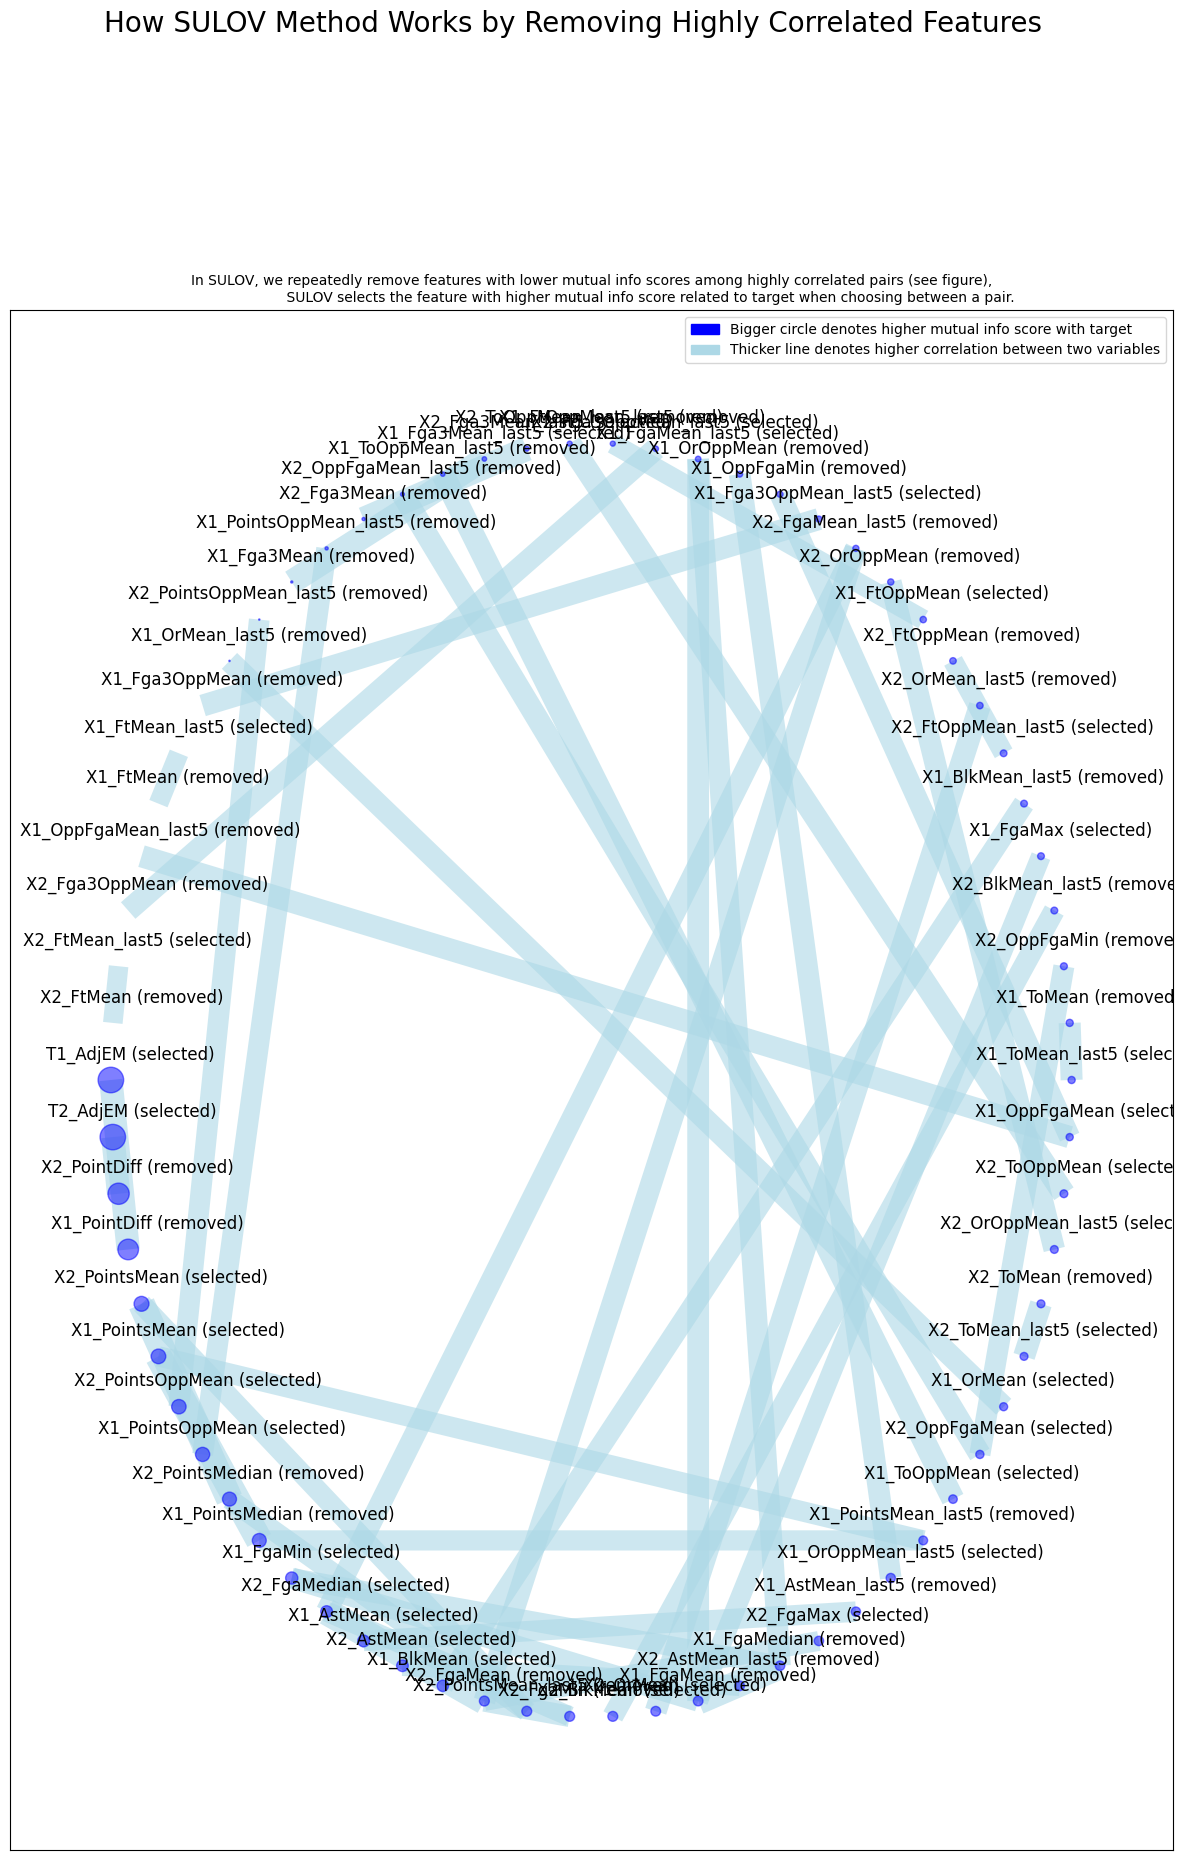

Performing recursive XGBoost feature selection from 49 features...
    Taking top 12 features per iteration...
    Number of booster rounds = 100
        Selected: ['SeedDiff', 'T1_AdjEM', 'T2_AdjEM', 'X1_OrMean', 'quality_march_T1', 'X2_OrMean', 'X2_PointsMean', 'X1_AstMean', 'X1_PointsOppMean', 'X2_ToOppMean', 'X1_PointsMean', 'quality_march_T2']
            Time taken for regular XGBoost feature selection = 1 seconds
        Selected: ['T2_AdjEM', 'T1_AdjEM', 'X1_BlkMean', 'quality_march_T2', 'X1_OrMean', 'X1_AstMean', 'X2_PointsMean', 'X1_PointsOppMean', 'X2_BlkMean', 'X1_DrMean_last5', 'X2_OrMean', 'X1_PointsMean']
            Time taken for regular XGBoost feature selection = 1 seconds
        Selected: ['X2_AstMean', 'X1_AstMean', 'X2_PointsOppMean', 'X1_PointsOppMean', 'X2_BlkMean', 'X1_BlkMean', 'X1_OrMean', 'X1_FtOppMean', 'X2_FgaMedian', 'X2_OrMean', 'X1_Fga3Mean_last5', 'X1_OppFgaMean']
            Time taken for regular XGBoost feature selection = 0 seconds
        Selecte

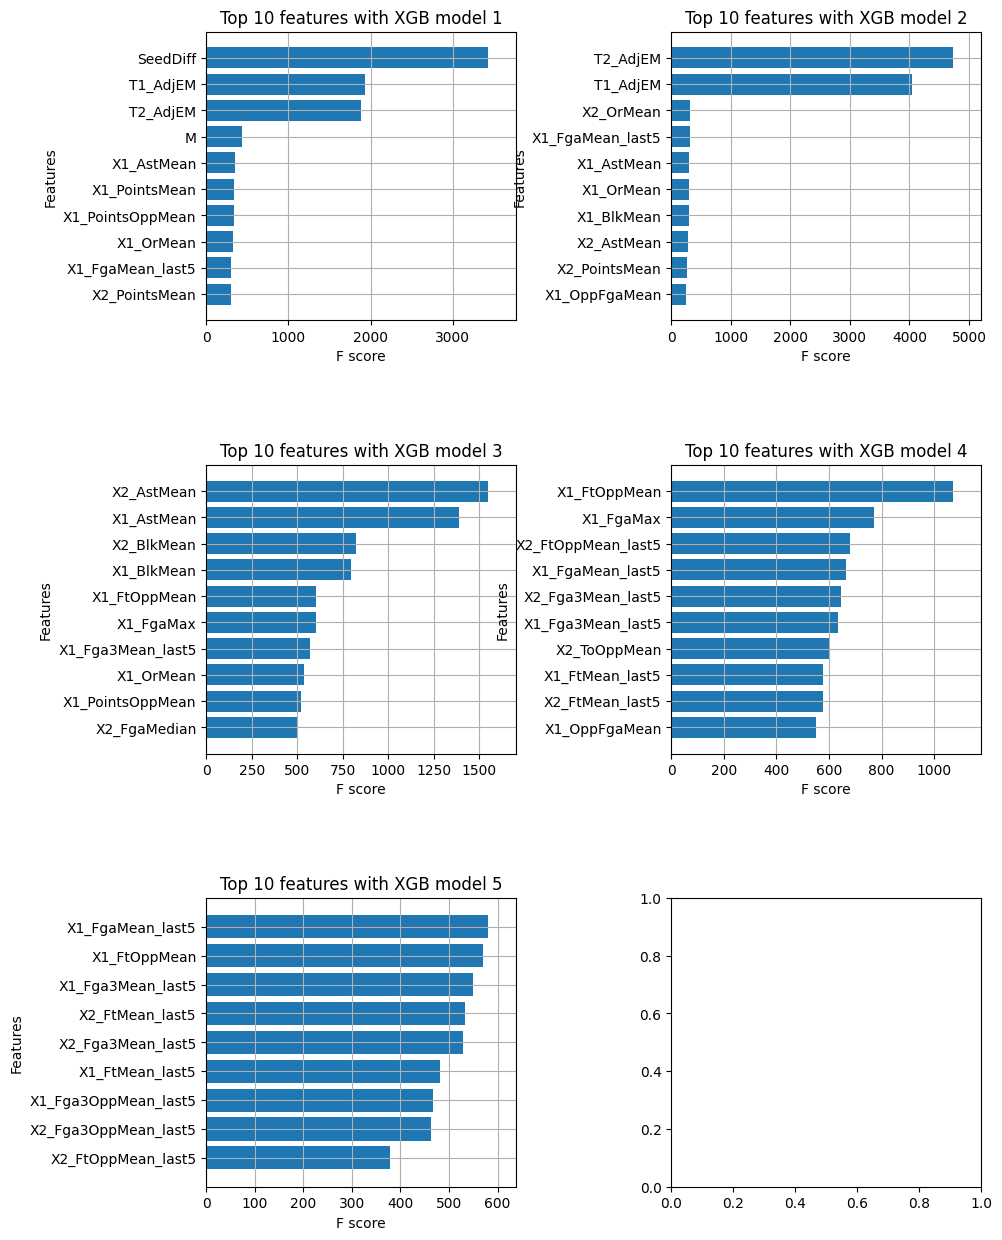

    time taken to run entire featurewiz = 5 second(s)
Recursive XGBoost selected 31 features...


In [ ]:
from featurewiz import FeatureWiz

feats = FeatureWiz(
    corr_limit=0.70,
    feature_engg="",
    category_encoders="",
    dask_xgboost_flag=False,
    nrows=None,
    verbose=2,
)
X_train_selected = feats.fit_transform(data_matrix[features], data_matrix["ResultDiff"])

In [79]:
features = feats.features

In [ ]:
X = data_matrix[features]
y = data_matrix["ResultDiff"]

In [ ]:
from sklearn.model_selection import KFold, cross_validate

study = optuna.create_study(direction="minimize")

kf = KFold(n_splits=5, shuffle=True, random_state=42)

func = lambda trial: objective(
    trial, X, y, cv=kf, scoring=make_scorer(mean_squared_error)
)
study.optimize(func, n_trials=100)

10.9740145439044
9.487857342976724
9.613192966553147
9.372112851872267
9.801649669027222
9.998524443520736
9.953287942108489
9.47008572386313
9.779263659048054
10.177700246832963
13.54798146738222
9.485143710820243
9.321398367642235
9.333049901948225
9.321103196270721
9.613353509057308
9.512614711400122
9.357342902134096
10.501788339627225
9.41148944129085
9.619750266117812
9.321243909112173
9.472472896387504
9.358106126605266
9.33341240531869
9.540530169241471
9.309513842713407
9.560773617877166
10.328780518853337
9.305870682687265
9.30313306846882
9.302802352251508
9.302311852299239
9.301841331544097
9.335646042074563
9.35147625234545
11.250932085443875
9.60521096304213
9.334154842185223
9.301022412143121
10.929023296609767
9.31410396329154
9.304268149341913
9.348254298626667
9.334181259453404
9.399789852503845
9.596660870843133
9.293943345720418
10.238219989338068
9.46254520118988
9.513738679347993
9.31801705659292
9.303406235553703
9.370275569146987
9.317513351982432
9.356279996028

In [82]:
print(f"The best MSE reached by this study: {(study.best_value)}.")

The best MSE reached by this study: 9.28730542980466.


In [83]:
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Best params:
	n_estimators: 2000
	learning_rate: 0.006693965999145883
	max_depth: 3
	subsample: 0.5
	colsample_bytree: 0.6


In [ ]:
dtrain = xgb.DMatrix(X.values, label=y.values)

In [85]:
best_params = study.best_params

In [ ]:
xgb_cv = []
repeat_cv = 5  # recommend 10 for final submission. Smaller for debugging.

for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
            params=best_params,
            dtrain=dtrain,
            obj=cauchyobj,
            num_boost_round=3000,
            folds=KFold(n_splits=5, shuffle=True, random_state=i),
            early_stopping_rounds=25,
            verbose_eval=50,
        )
    )

Fold repeater 0
[0]	train-rmse:17.44725+0.11717	test-rmse:17.44338+0.47054
[50]	train-rmse:15.45754+0.10175	test-rmse:15.52536+0.44107
[100]	train-rmse:14.10684+0.08725	test-rmse:14.24536+0.41200
[150]	train-rmse:13.18618+0.07681	test-rmse:13.38562+0.38954
[200]	train-rmse:12.56892+0.07349	test-rmse:12.82250+0.37509
[250]	train-rmse:12.15944+0.07683	test-rmse:12.46593+0.36014
[300]	train-rmse:11.86809+0.07645	test-rmse:12.22566+0.35351
[350]	train-rmse:11.66003+0.07632	test-rmse:12.06366+0.34854
[400]	train-rmse:11.50424+0.07726	test-rmse:11.95755+0.33802
[450]	train-rmse:11.38661+0.07652	test-rmse:11.88893+0.33618
[500]	train-rmse:11.29169+0.07960	test-rmse:11.83920+0.32992
[550]	train-rmse:11.21219+0.08042	test-rmse:11.80347+0.33118
[600]	train-rmse:11.14170+0.07960	test-rmse:11.77987+0.32854
[650]	train-rmse:11.07837+0.07983	test-rmse:11.76187+0.32562
[700]	train-rmse:11.02079+0.08010	test-rmse:11.74999+0.32490
[750]	train-rmse:10.96844+0.07987	test-rmse:11.74051+0.32216
[800]	train

In [ ]:
iteration_counts = [np.argmin(x["test-rmse-mean"].values) for x in xgb_cv]
val_mae = [np.min(x["test-rmse-mean"].values) for x in xgb_cv]
iteration_counts, val_mae

([1278, 1060, 1186, 1118, 1221],
 [11.685092198378442,
  11.707764870008342,
  11.697460176231681,
  11.70181703190651,
  11.682236781648186])

In [ ]:
# This is to get out-of-fold predictions
oof_preds = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    preds = y.copy()
    kfold = KFold(n_splits=5, shuffle=True, random_state=i)
    for train_index, val_index in kfold.split(X, y):
        dtrain_i = xgb.DMatrix(X.iloc[train_index], label=y.iloc[train_index])
        dval_i = xgb.DMatrix(X.iloc[val_index], label=y.iloc[val_index])
        model = xgb.train(
            params=best_params,
            dtrain=dtrain_i,
            num_boost_round=iteration_counts[i],
            verbose_eval=50,
        )
        preds[val_index] = model.predict(dval_i)
    oof_preds.append(np.clip(preds, -19, 19))

Fold repeater 0
Fold repeater 1
Fold repeater 2
Fold repeater 3
Fold repeater 4


In [ ]:
from scipy.interpolate import UnivariateSpline

val_cv = []
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i], np.where(y > 0, 1, 0)))
    dat = sorted(dat, key=lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]] = dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit, 0.025, 0.975)
    spline_fit[
        (data_matrix.Seed1 == 1)
        & (data_matrix.Seed2 == 16)
        & (data_matrix.T1_Points > data_matrix.T2_Points)
    ] = 0.99
    spline_fit[
        (data_matrix.Seed1 == 16)
        & (data_matrix.Seed2 == 1)
        & (data_matrix.T1_Points < data_matrix.T2_Points)
    ] = 0.01
    spline_fit[
        (data_matrix.Seed1 == 2)
        & (data_matrix.Seed2 == 15)
        & (data_matrix.T1_Points > data_matrix.T2_Points)
    ] = 0.975
    spline_fit[
        (data_matrix.Seed1 == 15)
        & (data_matrix.Seed2 == 2)
        & (data_matrix.T1_Points < data_matrix.T2_Points)
    ] = 0.025

    val_cv.append(
        pd.DataFrame(
            {
                "y": np.where(y > 0, 1, 0),
                "pred": spline_fit,
                "season": data_matrix.Season,
            }
        )
    )
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}")
val_cv = pd.concat(val_cv)
val_cv.groupby("season").apply(lambda x: log_loss(x.y, x.pred))

adjusted logloss of cvsplit 0: 0.49901580318959077
adjusted logloss of cvsplit 1: 0.5007711545432775
adjusted logloss of cvsplit 2: 0.49927978501041564
adjusted logloss of cvsplit 3: 0.5004917944086483
adjusted logloss of cvsplit 4: 0.4999081792105289


season
2003    0.525421
2004    0.500687
2005    0.509967
2006    0.560467
2007    0.446300
2008    0.476435
2009    0.496276
2010    0.491833
2011    0.494083
2012    0.474934
2013    0.522661
2014    0.491865
2015    0.443878
2016    0.520210
2017    0.466075
2018    0.542368
2019    0.427619
2021    0.541681
2022    0.541204
2023    0.556337
2024    0.473669
dtype: float64

In [90]:
sub = pd.read_csv("SampleSubmissionStage2.csv")

In [ ]:
sub["Season"] = sub["ID"].apply(lambda x: int(x.split("_")[0]))
sub["T1"] = sub["ID"].apply(lambda x: int(x.split("_")[1]))
sub["T2"] = sub["ID"].apply(lambda x: int(x.split("_")[2]))

In [ ]:
sub = (
    sub.merge(season_summary_X1, how="left", on=["Season", "T1"])
    .merge(season_summary_X2, how="left", on=["Season", "T2"])
    .merge(
        seeds[["Season", "TeamID", "Seed"]].rename(
            columns={"TeamID": "T1", "Seed": "Seed1"}
        ),
        how="left",
        on=["Season", "T1"],
    )
    .merge(
        seeds[["Season", "TeamID", "Seed"]].rename(
            columns={"TeamID": "T2", "Seed": "Seed2"}
        ),
        how="left",
        on=["Season", "T2"],
    )
    .assign(SeedDiff=lambda x: x.Seed1 - x.Seed2)
    .merge(
        glm_quality_T1.rename(
            columns={"T1_TeamID": "T1", "T1_quality": "quality_march_T1"}
        ),
        how="left",
        on=["Season", "T1"],
    )
    .merge(
        glm_quality_T2.rename(
            columns={"T2_TeamID": "T2", "T2_quality": "quality_march_T2"}
        ),
        how="left",
        on=["Season", "T2"],
    )
    .merge(elo_df_1[["Rating_Last", "T1", "Season"]], how="left", on=["Season", "T1"])
    .merge(
        elo_df_2[["Rating_Last", "T2", "Season"]],
        how="left",
        on=["Season", "T2"],
        suffixes=("_T1", "_T2"),
    )
    .merge(
        kenpom_ratings_T1.rename(columns={"T1_season": "Season", "T1_TeamID": "T1"})[
            ["Season", "T1", "T1_AdjEM"]
        ]
    )
    .merge(
        kenpom_ratings_T2.rename(columns={"T2_season": "Season", "T2_TeamID": "T2"})[
            ["Season", "T2", "T2_AdjEM"]
        ]
    )
)

In [93]:
X_test_selected = sub[features]
dtest = xgb.DMatrix(X_test_selected.values)

In [ ]:
sub_models = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    sub_models.append(
        xgb.train(
            params=best_params,
            dtrain=dtrain,
            num_boost_round=int(iteration_counts[i] * 1.05),
            verbose_eval=50,
        )
    )

Fold repeater 0
Fold repeater 1
Fold repeater 2
Fold repeater 3
Fold repeater 4


In [95]:
dtest = xgb.DMatrix(X_test_selected.values)

In [96]:
reg = xgb.XGBRegressor(**best_params)

In [ ]:
reg.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.006693965999145883,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=2000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
sub["Pred"] = np.clip(
    spline_model[0](np.clip(reg.predict(X_test_selected), -25, 25)), 0.025, 0.975
)

In [ ]:
sub.loc[sub["Pred"] > 0.5, "Pred"] *= 1  # This is calibrated by trial and error.
sub.loc[sub["Pred"] < 0.5, "Pred"] /= 1
print(sub["Pred"].mean())

0.7789029349791818


In [ ]:
sub[["ID", "Pred"]].to_csv("submission_2.csv", index=False)

In [ ]:
sub[(sub["T1"] == 1181)]["Pred"] = 1

In [ ]:
sub[(sub["T2"] == 1181)]["Pred"] = 0

In [ ]:
sub[(sub["Seed1"] == 1) & (sub["Seed2"] == 16)]["Pred"] = 1

In [ ]:
sub[(sub["Seed1"] == 16) & (sub["Seed2"] == 1)]["Pred"] = 0

In [ ]:
sub[(sub["Seed1"] == 15) & (sub["Seed2"] == 2)]["Pred"] = 0.98

In [ ]:
sub[(sub["Seed1"] == 2) & (sub["Seed2"] == 15)]["Pred"] = 0.02